# Malha

In [1]:
import xmltodict
import json
import pandas as pd
import matplotlib.pyplot as plt

pd.options.display.max_rows = 99


In [2]:
with open('malha.net.xml', 'rb') as f:
    malha_xml = xmltodict.parse(
        f, attr_prefix='', cdata_key='', dict_constructor=dict)

# print(json.dumps(malha_xml['net']['edge'], indent=4, ensure_ascii=False))


In [3]:
malha_viaria = []

for attr in malha_xml['net']['edge']:
    malha_viaria.append([attr['id'], attr['name'], attr['priority'],
                         attr['param'][0]['value'], attr['param'][1]['value']])

malha = pd.DataFrame(malha_viaria, columns=[
                     'id', 'name', 'priority', 'vmax', 'vmin'])

malha.sort_values('priority', inplace=True, ascending=False)
malha[['priority', 'vmax', 'vmin']] = malha[['priority', 'vmax', 'vmin']].apply(pd.to_numeric)

malha.head()


,id,name,priority,vmax,vmin
11,gneE2,Av.Ver.Abrahão João Francisco,5,5.94,4.67
23,gneE8,Av.Ver.Abrahão João Francisco,5,5.94,4.67
22,gneE7,Av.Ver.Abrahão João Francisco,5,5.94,4.67
6,gneE14,Av.Ver.Abrahão João Francisco,5,5.94,4.67
7,gneE15,Av.Ver.Abrahão João Francisco,5,5.94,4.67


# Rotas

In [4]:
with open('demanda.rou.xml', 'rb') as f:
    dem_xml = xmltodict.parse(
        f, attr_prefix='', cdata_key='', dict_constructor=dict)

# print(json.dumps(dem_xml['routes']['route'], indent=4, ensure_ascii=False))

In [5]:
rotas = pd.DataFrame(dem_xml['routes']['route'])

rotas.drop(columns=['color'], inplace=True)

rotas.head()

,edges,id
0,gneE0 gneE1 gneE2 gneE3 gneE4,route_0
1,gneE0 gneE1 gneE2 gneE3 gneE15 gneE16 gneE17,route_1
2,gneE10 gneE11 gneE12 gneE14 gneE2 gneE24,route_10
3,gneE23 gneE15 gneE7 gneE8 gneE9,route_11
4,gneE23 gneE15 gneE16 gneE17,route_12


# Resultados da simulação

In [6]:
#!python3 xml2csv.py full.output.xml

In [7]:
result_sumo = pd.read_csv('full.output.csv', sep=';')
result_sumo.head()

,data_timestep,vehicle_CO,vehicle_CO2,vehicle_HC,vehicle_NOx,vehicle_PMx,vehicle_angle,vehicle_eclass,vehicle_electricity,vehicle_fuel,...,lane_NOx,lane_PMx,lane_electricity,lane_fuel,lane_id,lane_maxspeed,lane_meanspeed,lane_noise,lane_occupancy,lane_vehicle_count
0,0.0,164.78,2624.72,0.81,1.2,0.07,53.33,HBEFA3/PC_G_EU4,0.0,1.13,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.0,164.78,2624.72,0.81,1.2,0.07,232.28,HBEFA3/PC_G_EU4,0.0,1.13,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.0,164.78,2624.72,0.81,1.2,0.07,96.77,HBEFA3/PC_G_EU4,0.0,1.13,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.0,164.78,2624.72,0.81,1.2,0.07,351.62,HBEFA3/PC_G_EU4,0.0,1.13,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.0,164.78,2624.72,0.81,1.2,0.07,170.95,HBEFA3/PC_G_EU4,0.0,1.13,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
result_sumo.columns

Index(['data_timestep', 'vehicle_CO', 'vehicle_CO2', 'vehicle_HC',
       'vehicle_NOx', 'vehicle_PMx', 'vehicle_angle', 'vehicle_eclass',
       'vehicle_electricity', 'vehicle_fuel', 'vehicle_id', 'vehicle_lane',
       'vehicle_noise', 'vehicle_pos', 'vehicle_route', 'vehicle_speed',
       'vehicle_type', 'vehicle_waiting', 'vehicle_x', 'vehicle_y', 'edge_id',
       'edge_traveltime', 'lane_CO', 'lane_CO2', 'lane_HC', 'lane_NOx',
       'lane_PMx', 'lane_electricity', 'lane_fuel', 'lane_id', 'lane_maxspeed',
       'lane_meanspeed', 'lane_noise', 'lane_occupancy', 'lane_vehicle_count'],
      dtype='object')

In [9]:
result_sumo['vehicle_edge'] = result_sumo['vehicle_lane'].str.split(
    '_').str[0]

veic_sumo = result_sumo[result_sumo['vehicle_route'].notnull(
)][['data_timestep', 'vehicle_route', 'vehicle_edge', 'vehicle_speed']]

veic_sumo.head()


,data_timestep,vehicle_route,vehicle_edge,vehicle_speed
0,0.0,route_0,gneE0,0.0
1,0.0,route_4,gneE5,0.0
2,0.0,route_10,gneE10,0.0
3,0.0,route_11,gneE23,0.0
4,0.0,route_14,gneE22,0.0


# resultados por rota

In [10]:
rotas_det = {}

for idx, row in rotas.iterrows():
    rotas_det[row['id']] = {'edge': [], 'vmax': [], 'vmin': [], 'sumo': []}
    for edge in row['edges'].split():
        rotas_det[row['id']]['edge'].append(edge)
        rotas_det[row['id']]['vmax'].append(
            malha[malha['id'] == edge]['vmax'].values[0])
        rotas_det[row['id']]['vmin'].append(
            malha[malha['id'] == edge]['vmin'].values[0])
        rotas_det[row['id']]['sumo'].append(
            veic_sumo[veic_sumo['vehicle_edge'] == edge]['vehicle_speed'].values[0])


In [11]:
rotas_det.keys()

dict_keys(['route_0', 'route_1', 'route_10', 'route_11', 'route_12', 'route_13', 'route_14', 'route_15', 'route_16', 'route_17', 'route_18', 'route_19', 'route_2', 'route_20', 'route_3', 'route_4', 'route_5', 'route_6', 'route_7', 'route_8', 'route_9'])

In [12]:
rotas_det['route_0']

{'edge': ['gneE0', 'gneE1', 'gneE2', 'gneE3', 'gneE4'],
 'vmax': [16.0, 4.66, 5.94, 8.5, 16.0],
 'vmin': [11.2, 2.55, 4.67, 5.95, 11.2],
 'sumo': [0.0, 8.89, 8.12, 7.28, 8.58]}

## Gráfico com a progressão da rota na simulação com a sobreposição da velocidade máxima e mínima esperada.

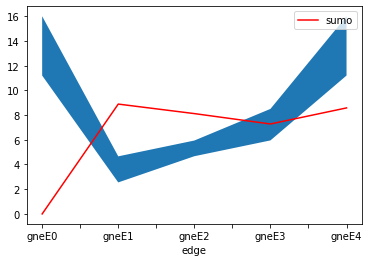

In [13]:
rota_plot = pd.DataFrame.from_dict(rotas_det['route_0'])
col = rota_plot.loc[: , 'vmax':'vmin']
#malha['mean'] = col.mean(axis=1)
ax  = rota_plot.plot(x='edge', y='sumo', c='red')
plt.fill_between(x='edge',y1='vmin',y2='vmax', data=rota_plot)

<function matplotlib.pyplot.show(close=None, block=None)>

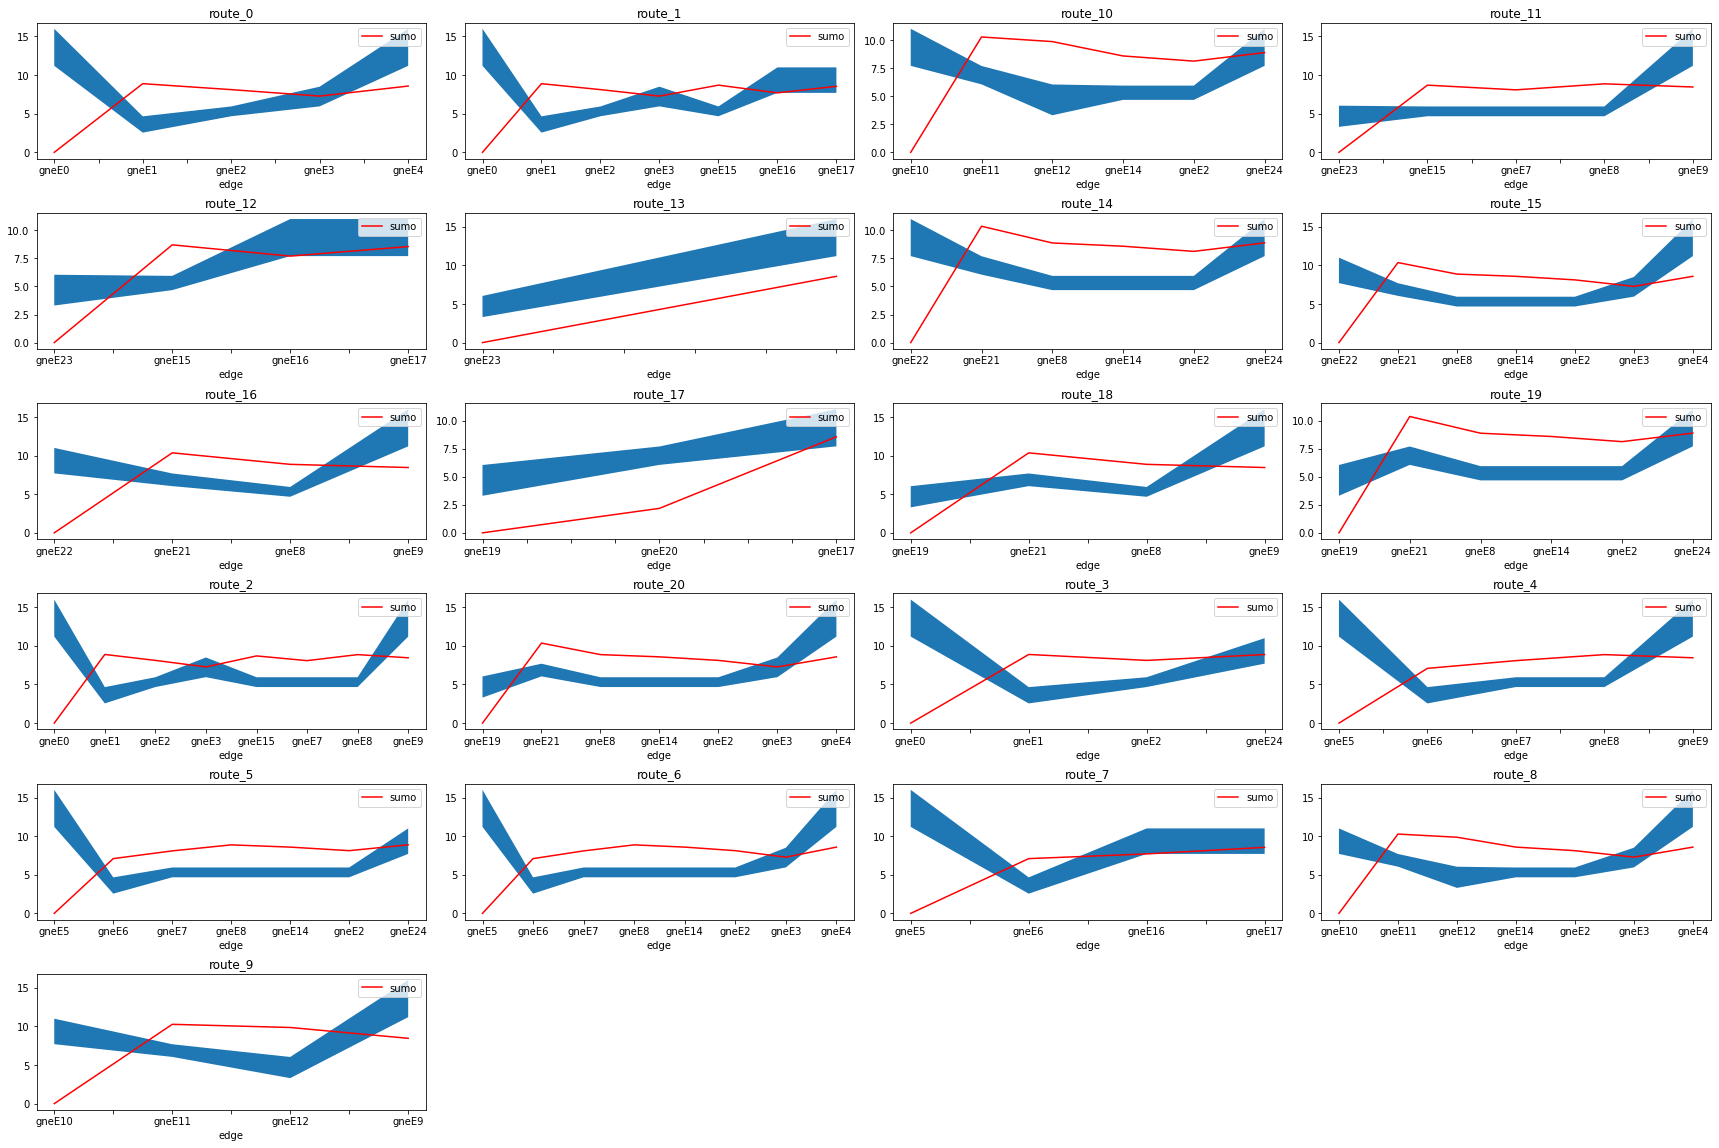

In [14]:
fig = plt.figure(figsize=(30, 20))
fig.subplots_adjust(hspace = .4, wspace=.1)

for idx, rota in enumerate(rotas_det.keys()):
    rota_plot = pd.DataFrame.from_dict(rotas_det[rota])
    ax  = fig.add_subplot(6,4,idx+1)
    rota_plot.plot(x='edge', y='sumo', c='red', ax=ax)
    plt.title(rota)
    plt.fill_between(x='edge',y1='vmin',y2='vmax', data=rota_plot)

plt.show